In [10]:
%matplotlib inline
import pandas as pd

In [2]:
tmap = pd.read_csv('../data/Tmap_2005.csv')

In [3]:
tmap

,일자,지역(시도),지역(시군구),검색지명,검색지유형1,검색지유형2,검색지유형3,검색지랭킹(시군구내)
0,20200510,강원,삼척시,쏠비치삼척,여행/레저,숙박,콘도/리조트,1
1,20200510,강원,삼척시,삼척해양레일바이크용화정거장,여행/레저,레저/스포츠,레저/스포츠기타,2
2,20200510,강원,삼척시,장호항,교통편의,교통시설,항구,3
3,20200510,강원,삼척시,삼척해양레일바이크궁촌정거장,여행/레저,레저/스포츠,레저/스포츠기타,4
4,20200510,강원,삼척시,해신당공원,여행/레저,관광명소,공원,5
...,...,...,...,...,...,...,...,...
232495,20200503,충북,청주시 청원구,초정약수세종스파텔,여행/레저,관광명소,온천,26
232496,20200503,충북,청주시 청원구,더휴센트럴파크아파트,건물/시설,주요건물,아파트단지,27
232497,20200503,충북,청주시 청원구,오창대성베르힐아파트,건물/시설,주요건물,아파트단지,28
232498,20200503,충북,청주시 청원구,오창모아미래도와이드시티아파트,건물/시설,주요건물,아파트단지,29


In [4]:
tmap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232500 entries, 0 to 232499
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   일자           232500 non-null  int64 
 1   지역(시도)       232500 non-null  object
 2   지역(시군구)      232500 non-null  object
 3   검색지명         232500 non-null  object
 4   검색지유형1       232500 non-null  object
 5   검색지유형2       232500 non-null  object
 6   검색지유형3       232500 non-null  object
 7   검색지랭킹(시군구내)  232500 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 8.9+ MB


# 서울지역만 하는 경우

In [5]:
c1 = tmap['지역(시도)'] == '서울'
# c2 = tmap['일자']==20200510
seoul = tmap.loc[c1,:]
seoul

,일자,지역(시도),지역(시군구),검색지명,검색지유형1,검색지유형2,검색지유형3,검색지랭킹(시군구내)
1140,20200510,서울,강동구,고덕래미안힐스테이트아파트,건물/시설,주요건물,아파트브랜드,1
1141,20200510,서울,강동구,천호역,교통편의,교통시설,지하철역,2
1142,20200510,서울,강동구,고덕그라시움아파트,건물/시설,주요건물,아파트단지,3
1143,20200510,서울,강동구,현대백화점천호점,쇼핑,대형유통점,백화점,4
1144,20200510,서울,강동구,강동롯데캐슬퍼스트아파트,건물/시설,주요건물,아파트브랜드,5
...,...,...,...,...,...,...,...,...
232285,20200503,서울,서대문구,홍제센트럴아이파크아파트,건물/시설,주요건물,아파트브랜드,26
232286,20200503,서울,서대문구,홍제한양아파트,건물/시설,주요건물,아파트단지,27
232287,20200503,서울,서대문구,래미안남가좌2차아파트,건물/시설,주요건물,아파트브랜드,28
232288,20200503,서울,서대문구,북한산더샵아파트,건물/시설,주요건물,아파트브랜드,29


In [6]:
cnt_seoul = seoul['검색지명'].value_counts()
cnt_seoul

서울역         42
건대입구역       38
북서울꿈의숲      36
천호역         33
어린이대공원      33
            ..
큰믿음유신교회      1
청계산입구역       1
뉴타운장례식장      1
경복고등학교       1
더컨벤션영등포점     1
Name: 검색지명, Length: 1230, dtype: int64

In [16]:
type(cnt_seoul)
data = {'name':[], 'count':[]}
for idx, i in enumerate(cnt_seoul.index):
    if cnt_seoul[idx]<=20: break
    data['name'].append(i)
    data['count'].append(cnt_seoul[idx])
data
cnt_df = pd.DataFrame(data)
cnt_df
# 음 한달동안 서울에서 20회 이하는 삭제했을때 

,name,count
0,서울역,42
1,건대입구역,38
2,북서울꿈의숲,36
3,천호역,33
4,어린이대공원,33
...,...,...
629,마포자이3차아파트,21
630,대한상공회의소,21
631,서울북부지방법원,21
632,서울중앙지방법원,21


<AxesSubplot:>

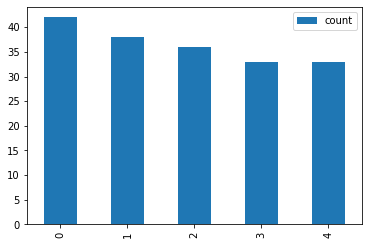

In [15]:
cnt_df.plot(kind='bar')